In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import optuna
from optuna.trial import TrialState
from optuna.integration import PyTorchLightningPruningCallback
import warnings
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Dict, List, Tuple, Optional
import pickle

warnings.filterwarnings('ignore')

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo disponible: {device}")

# Configurar semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

Dispositivo disponible: cpu


In [2]:
# Cargar datos
print("Cargando datos...")
df_train = pd.read_parquet('../../Datos/df_train.parquet')
df_test = pd.read_parquet('../../Datos/df_test.parquet')

print(f"Forma df_train: {df_train.shape}")
print(f"Forma df_test: {df_test.shape}")
print(f"\nColumnas: {df_train.columns.tolist()}")

# Crear índice temporal combinando año y semana
def create_datetime_index(df):
    """Crea un índice datetime a partir de año y semana"""
    df = df.copy()
    # Convertir año y semana a datetime
    df['fecha'] = pd.to_datetime(df['anio'].astype(str) + '-W' + 
                                 df['semana'].astype(str).str.zfill(2) + '-1', 
                                 format='%Y-W%W-%w')
    return df

df_train = create_datetime_index(df_train)
df_test = create_datetime_index(df_test)

# Información básica
print("\n=== INFORMACIÓN BÁSICA ===")
print(f"Número de barrios únicos: {df_train['id_bar'].nunique()}")
print(f"Rango de fechas train: {df_train['fecha'].min()} a {df_train['fecha'].max()}")
print(f"Rango de fechas test: {df_test['fecha'].min()} a {df_test['fecha'].max()}")
print(f"Valores únicos de ESTRATO: {sorted(df_train['ESTRATO'].unique())}")

# Verificar valores nulos
print(f"\nValores nulos en train: {df_train.isnull().sum().sum()}")
print(f"Valores nulos en test: {df_test.isnull().sum().sum()}")

Cargando datos...
Forma df_train: (3680, 20)
Forma df_test: (520, 19)

Columnas: ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'dengue', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']

=== INFORMACIÓN BÁSICA ===
Número de barrios únicos: 10
Rango de fechas train: 2015-01-05 00:00:00 a 2022-01-03 00:00:00
Rango de fechas test: 2022-01-03 00:00:00 a 2022-12-26 00:00:00
Valores únicos de ESTRATO: [np.float64(1.0), np.float64(2.0), np.float64(3.0)]

Valores nulos en train: 0
Valores nulos en test: 0


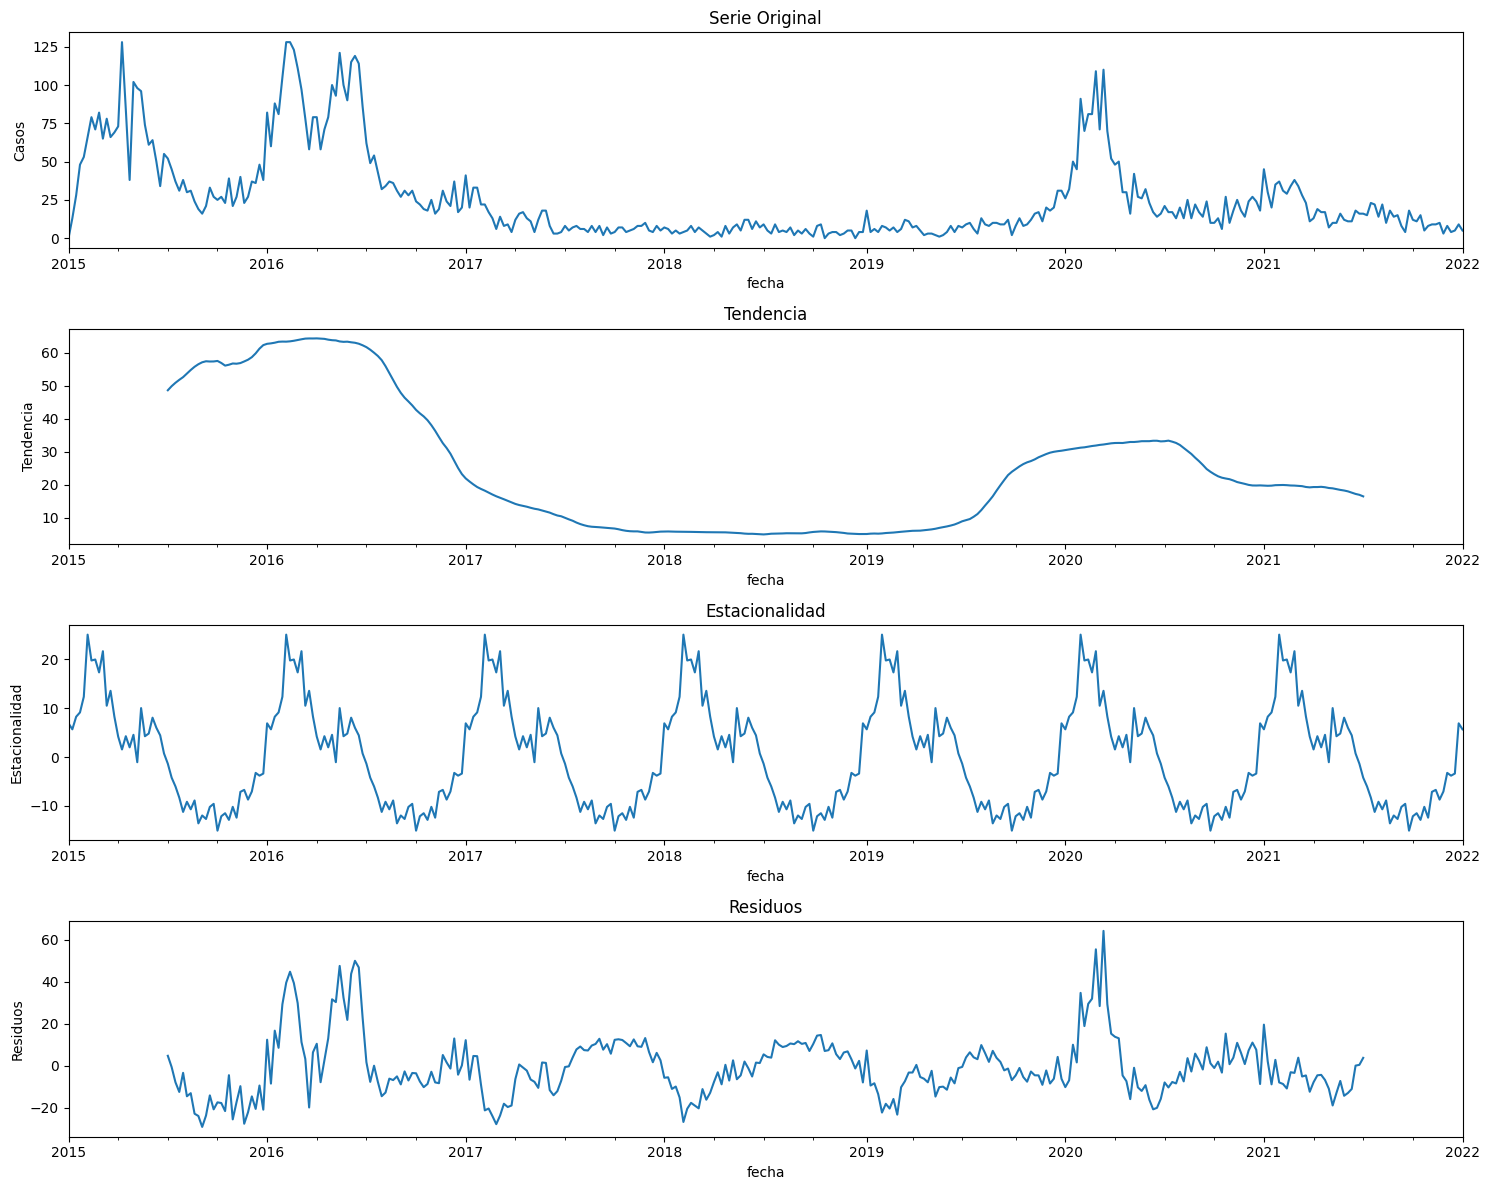

In [3]:
# Análisis global: agregar casos de dengue para todos los barrios
dengue_global = df_train.groupby('fecha')['dengue'].sum().reset_index()

# Crear visualización interactiva con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=dengue_global['fecha'],
    y=dengue_global['dengue'],
    mode='lines',
    name='Casos totales de dengue',
    line=dict(color='red', width=2)
))

fig.update_layout(
    title='Serie de Tiempo Global de Casos de Dengue (Todos los Barrios)',
    xaxis_title='Fecha',
    yaxis_title='Casos Totales',
    hovermode='x unified',
    height=500
)
fig.show()

# Análisis de estacionalidad - descomposición
from statsmodels.tsa.seasonal import seasonal_decompose

# Asegurar frecuencia semanal
dengue_global_ts = dengue_global.set_index('fecha')['dengue']
dengue_global_ts = dengue_global_ts.asfreq('W-MON', method='ffill')

# Descomposición
decomposition = seasonal_decompose(dengue_global_ts, model='additive', period=52)

# Visualizar descomposición
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

dengue_global_ts.plot(ax=axes[0], title='Serie Original')
axes[0].set_ylabel('Casos')

decomposition.trend.plot(ax=axes[1], title='Tendencia')
axes[1].set_ylabel('Tendencia')

decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad')
axes[2].set_ylabel('Estacionalidad')

decomposition.resid.plot(ax=axes[3], title='Residuos')
axes[3].set_ylabel('Residuos')

plt.tight_layout()
plt.show()

In [4]:
# Seleccionar muestra de barrios para análisis detallado
barrios_muestra = df_train['id_bar'].unique()[:5]
print(f"Barrios seleccionados para análisis: {barrios_muestra}")

# Crear subplots para comparar series de tiempo
fig = make_subplots(
    rows=len(barrios_muestra), 
    cols=1,
    subplot_titles=[f'Barrio {b}' for b in barrios_muestra],
    shared_xaxes=True,
    vertical_spacing=0.05
)

for i, barrio in enumerate(barrios_muestra):
    data_barrio = df_train[df_train['id_bar'] == barrio].sort_values('fecha')
    
    fig.add_trace(
        go.Scatter(
            x=data_barrio['fecha'],
            y=data_barrio['dengue'],
            mode='lines',
            name=f'Barrio {barrio}',
            showlegend=True
        ),
        row=i+1, col=1
    )

fig.update_layout(
    height=200*len(barrios_muestra),
    title_text="Comparación de Series de Tiempo por Barrio",
    showlegend=True
)
fig.update_xaxes(title_text="Fecha", row=len(barrios_muestra), col=1)
fig.update_yaxes(title_text="Casos")

fig.show()

Barrios seleccionados para análisis: [4 5 3 8 9]


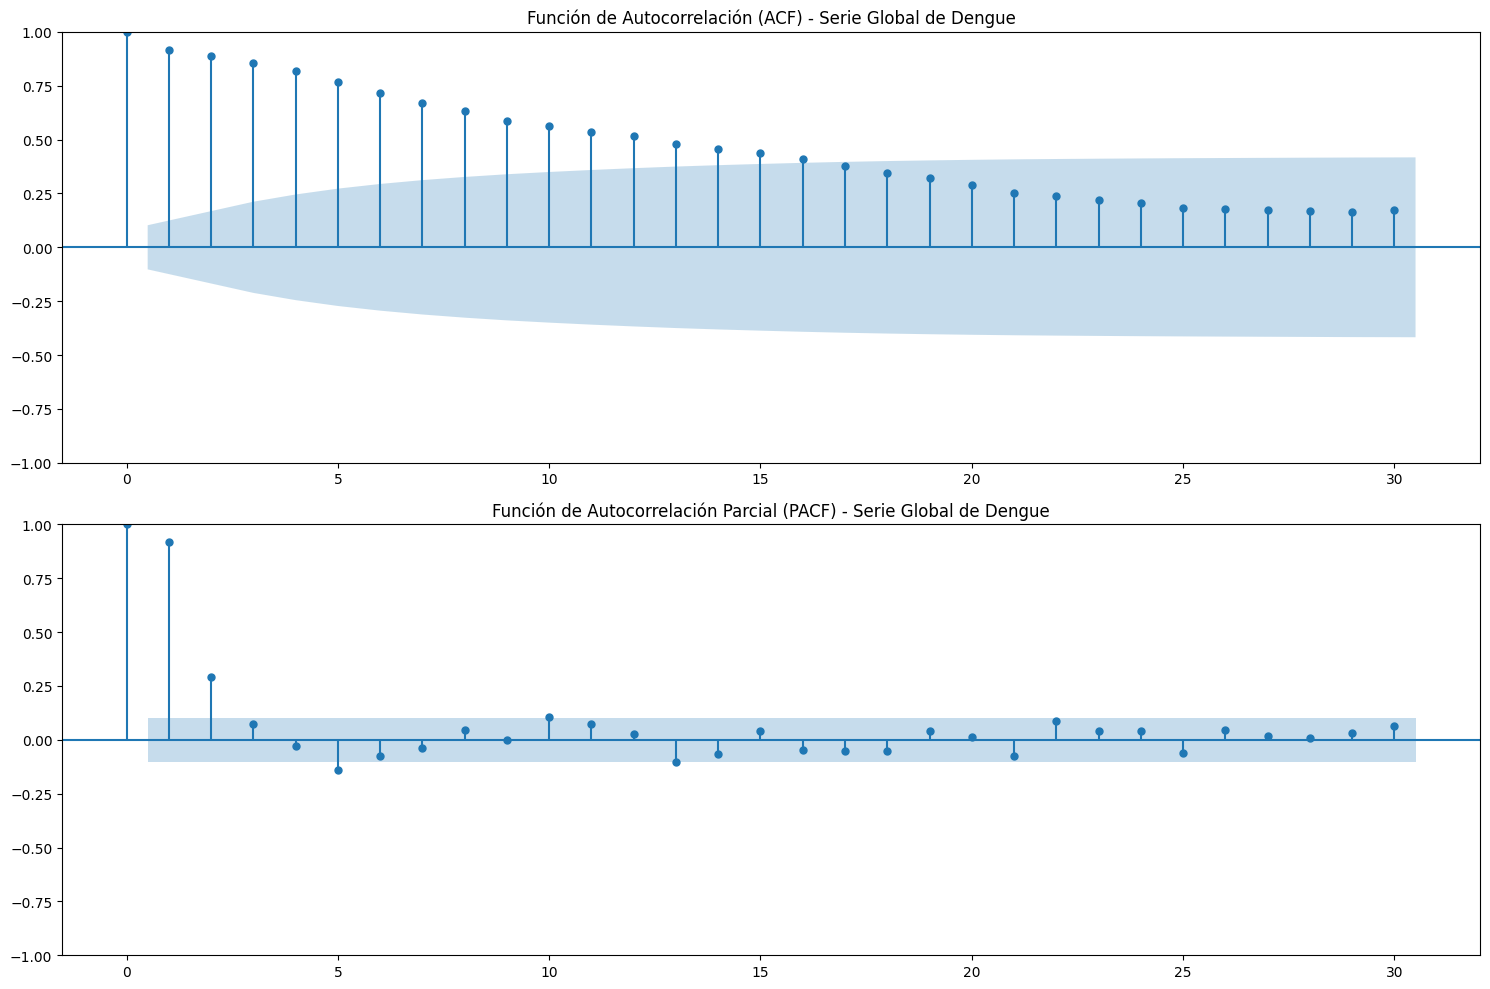

Basado en el análisis ACF/PACF, las correlaciones significativas sugieren
usar una ventana de 8-16 semanas para las predicciones.


In [5]:
# Análisis ACF y PACF para determinar longitud de secuencia óptima
# Usar serie global para este análisis
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# ACF
plot_acf(dengue_global_ts.dropna(), lags=30, ax=axes[0])
axes[0].set_title('Función de Autocorrelación (ACF) - Serie Global de Dengue')

# PACF
plot_pacf(dengue_global_ts.dropna(), lags=30, ax=axes[1])
axes[1].set_title('Función de Autocorrelación Parcial (PACF) - Serie Global de Dengue')

plt.tight_layout()
plt.show()

print("Basado en el análisis ACF/PACF, las correlaciones significativas sugieren")
print("usar una ventana de 8-16 semanas para las predicciones.")

In [6]:
class DataPreprocessor:
    """Clase para manejar todo el preprocesamiento de datos"""
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.feature_columns = None
        self.estrato_columns = None
        
    def prepare_features(self, df):
        """Prepara las características incluyendo one-hot encoding de ESTRATO"""
        df = df.copy()
        
        # One-hot encoding de ESTRATO
        estrato_encoded = self.encoder.fit_transform(df[['ESTRATO']])
        estrato_df = pd.DataFrame(
            estrato_encoded,
            columns=[f'ESTRATO_{int(cat)}' for cat in self.encoder.categories_[0]],
            index=df.index
        )
        
        # Combinar con el dataframe original
        df = pd.concat([df, estrato_df], axis=1)
        
        # Definir columnas de características (excluyendo las no necesarias)
        exclude_cols = ['id', 'id_bar', 'anio', 'semana', 'fecha', 'ESTRATO', 'dengue', '__index_level_0__']
        self.feature_columns = [col for col in df.columns if col not in exclude_cols]
        self.estrato_columns = [col for col in df.columns if col.startswith('ESTRATO_')]
        
        print(f"Características totales: {len(self.feature_columns)}")
        print(f"Columnas de ESTRATO: {self.estrato_columns}")
        
        return df
    
    def fit_scaler(self, df_train):
        """Ajusta el escalador solo con datos de entrenamiento"""
        # Ajustar solo con características numéricas (excluyendo one-hot encoded)
        numeric_features = [col for col in self.feature_columns if col not in self.estrato_columns]
        self.scaler.fit(df_train[numeric_features])
        return self
    
    def transform_features(self, df):
        """Transforma las características usando el escalador ajustado"""
        df = df.copy()
        
        # Escalar solo características numéricas
        numeric_features = [col for col in self.feature_columns if col not in self.estrato_columns]
        df[numeric_features] = self.scaler.transform(df[numeric_features])
        
        return df

# Aplicar preprocesamiento
preprocessor = DataPreprocessor()

# Preparar características
df_train = preprocessor.prepare_features(df_train)
df_test = preprocessor.prepare_features(df_test)

# Ajustar escalador SOLO con datos de entrenamiento
preprocessor.fit_scaler(df_train)

# Transformar ambos conjuntos
df_train_scaled = preprocessor.transform_features(df_train)
df_test_scaled = preprocessor.transform_features(df_test)

print("\nForma después del preprocesamiento:")
print(f"Train: {df_train_scaled.shape}")
print(f"Test: {df_test_scaled.shape}")

Características totales: 17
Columnas de ESTRATO: ['ESTRATO_1', 'ESTRATO_2', 'ESTRATO_3']
Características totales: 17
Columnas de ESTRATO: ['ESTRATO_1', 'ESTRATO_2', 'ESTRATO_3']

Forma después del preprocesamiento:
Train: (3680, 24)
Test: (520, 23)


In [7]:
class DengueTimeSeriesDataset(Dataset):
    """Dataset personalizado para series de tiempo de dengue"""
    
    def __init__(self, data, barrios, sequence_length, feature_columns, is_train=True):
        self.data = data
        self.barrios = barrios
        self.sequence_length = sequence_length
        self.feature_columns = feature_columns
        self.is_train = is_train
        self.samples = []
        
        # Crear muestras por barrio
        for barrio in self.barrios:
            barrio_data = self.data[self.data['id_bar'] == barrio].sort_values('fecha')
            
            if len(barrio_data) > sequence_length:
                for i in range(len(barrio_data) - sequence_length):
                    if is_train:
                        # Para entrenamiento, incluir el target
                        self.samples.append({
                            'barrio': barrio,
                            'start_idx': i,
                            'end_idx': i + sequence_length
                        })
                    else:
                        # Para predicción, solo necesitamos la última ventana
                        if i == len(barrio_data) - sequence_length:
                            self.samples.append({
                                'barrio': barrio,
                                'start_idx': i,
                                'end_idx': i + sequence_length
                            })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        barrio_data = self.data[self.data['id_bar'] == sample['barrio']].sort_values('fecha')
        
        # Obtener secuencia
        sequence_data = barrio_data.iloc[sample['start_idx']:sample['end_idx']]
        
        # Features (X)
        X = torch.FloatTensor(sequence_data[self.feature_columns].values)
        
        if self.is_train:
            # Target (y) - siguiente valor de dengue
            if sample['end_idx'] < len(barrio_data):
                y = torch.FloatTensor([barrio_data.iloc[sample['end_idx']]['dengue']])
            else:
                y = torch.FloatTensor([sequence_data.iloc[-1]['dengue']])
        else:
            y = torch.FloatTensor([0])  # Placeholder
        
        return X, y, sample['barrio']

def create_dataloaders(df_train_scaled, df_test_scaled, preprocessor, 
                      sequence_length=12, batch_size=32, val_years=[2021]):
    """Crea los dataloaders para entrenamiento, validación y predicción"""
    
    # Separar datos de entrenamiento y validación
    train_data = df_train_scaled[~df_train_scaled['anio'].isin(val_years)]
    val_data = df_train_scaled[df_train_scaled['anio'].isin(val_years)]
    
    # Obtener barrios únicos
    barrios = df_train_scaled['id_bar'].unique()
    
    # Crear datasets
    train_dataset = DengueTimeSeriesDataset(
        train_data, barrios, sequence_length, 
        preprocessor.feature_columns, is_train=True
    )
    
    val_dataset = DengueTimeSeriesDataset(
        val_data, barrios, sequence_length, 
        preprocessor.feature_columns, is_train=True
    )
    
    full_train_dataset = DengueTimeSeriesDataset(
        df_train_scaled, barrios, sequence_length, 
        preprocessor.feature_columns, is_train=True
    )
    
    # Crear dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )
    
    full_train_loader = DataLoader(
        full_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    
    print(f"Muestras de entrenamiento: {len(train_dataset)}")
    print(f"Muestras de validación: {len(val_dataset)}")
    print(f"Muestras totales: {len(full_train_dataset)}")
    
    return train_loader, val_loader, full_train_loader

In [8]:
class DengueLSTM(nn.Module):
    """Modelo LSTM para predicción de dengue"""
    
    def __init__(self, input_size, hidden_size=100, n_layers=2, dropout=0.2):
        super(DengueLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        
        # Layer normalization para cada capa LSTM
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_size) for _ in range(n_layers)
        ])
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Capa de salida
        self.fc = nn.Linear(hidden_size, 1)
        
        # Activación ReLU para asegurar predicciones no negativas
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        batch_size = x.size(0)
        
        # Inicializar hidden state
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(x.device)
        
        # LSTM forward
        lstm_out, (hidden, cell) = self.lstm(x, (h0, c0))
        
        # Aplicar layer norm al output
        lstm_out = self.layer_norms[-1](lstm_out)
        
        # Usar la última salida temporal
        last_output = lstm_out[:, -1, :]
        
        # Dropout
        last_output = self.dropout(last_output)
        
        # Capa fully connected
        output = self.fc(last_output)
        
        # ReLU para asegurar valores no negativos
        output = self.relu(output)
        
        return output

def train_epoch(model, dataloader, optimizer, criterion, device):
    """Entrena el modelo por una época"""
    model.train()
    total_loss = 0
    
    for batch_X, batch_y, _ in dataloader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions.squeeze(), batch_y.squeeze())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion, device):
    """Evalúa el modelo"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y, _ in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            predictions = model(batch_X)
            loss = criterion(predictions.squeeze(), batch_y.squeeze())
            
            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_targets.extend(batch_y.cpu().numpy().flatten())
    
    mae = np.mean(np.abs(np.array(all_predictions) - np.array(all_targets)))
    
    return total_loss / len(dataloader), mae

In [ ]:
def objective(trial, df_train_scaled, preprocessor, device):
    """Función objetivo para Optuna"""
    
    # Hiperparámetros a optimizar
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'hidden_size': trial.suggest_int('hidden_size', 50, 150, step=25),
        'sequence_length': trial.suggest_int('sequence_length', 8, 16, step=2),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5)
    }
    
    # Crear dataloaders con los hiperparámetros
    train_loader, val_loader, _ = create_dataloaders(
        df_train_scaled, None, preprocessor,
        sequence_length=params['sequence_length'],
        batch_size=params['batch_size'],
        val_years=[2021]
    )
    
    # Crear modelo
    input_size = len(preprocessor.feature_columns)
    model = DengueLSTM(
        input_size=input_size,
        hidden_size=params['hidden_size'],
        n_layers=params['n_layers'],
        dropout=params['dropout']
    ).to(device)
    
    # Optimizador y función de pérdida
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss()
    
    # Early stopping
    best_val_mae = float('inf')
    patience = 20
    patience_counter = 0
    
    # Entrenar por un número fijo de épocas
    n_epochs = 100
    
    for epoch in range(n_epochs):
        # Entrenar
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Evaluar
        val_loss, val_mae = evaluate_model(model, val_loader, criterion, device)
        
        # Early stopping
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
        
        # Reportar a Optuna
        trial.report(val_mae, epoch)
        
        # Pruning
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_mae

# Ejecutar búsqueda de hiperparámetros
print("Iniciando búsqueda de hiperparámetros con Optuna...")

study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

# Optimizar
study.optimize(
    lambda trial: objective(trial, df_train_scaled, preprocessor, device),
    n_trials=100#,
    #timeout=3600  # 1 hora máximo
)

# Mostrar mejores hiperparámetros
print("\n=== MEJORES HIPERPARÁMETROS ===")
best_params = study.best_params
for key, value in best_params.items():
    print(f"{key}: {value}")
print(f"\nMejor MAE en validación: {study.best_value:.4f}")

# Visualizar importancia de hiperparámetros
fig = optuna.visualization.plot_param_importances(study)
fig.show()

[I 2025-06-18 13:49:28,059] A new study created in memory with name: no-name-21f849cf-5a72-41f8-a13f-d76241fbd8b1


Iniciando búsqueda de hiperparámetros con Optuna...
Muestras de entrenamiento: 3010
Muestras de validación: 390
Muestras totales: 3540


[I 2025-06-18 13:52:28,909] Trial 0 finished with value: 1.4861059188842773 and parameters: {'learning_rate': 0.00799174836288062, 'batch_size': 64, 'n_layers': 2, 'hidden_size': 100, 'sequence_length': 14, 'dropout': 0.45865514783413497}. Best is trial 0 with value: 1.4861059188842773.


Muestras de entrenamiento: 3030
Muestras de validación: 410
Muestras totales: 3560


[I 2025-06-18 13:55:09,388] Trial 1 finished with value: 1.7193790674209595 and parameters: {'learning_rate': 0.00015564737814174307, 'batch_size': 64, 'n_layers': 2, 'hidden_size': 150, 'sequence_length': 12, 'dropout': 0.28811206085912555}. Best is trial 0 with value: 1.4861059188842773.


Muestras de entrenamiento: 3030
Muestras de validación: 410
Muestras totales: 3560


[I 2025-06-18 13:57:03,335] Trial 2 finished with value: 1.062119483947754 and parameters: {'learning_rate': 1.092475259913126e-05, 'batch_size': 32, 'n_layers': 2, 'hidden_size': 50, 'sequence_length': 12, 'dropout': 0.2775869980339168}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 3050
Muestras de validación: 430
Muestras totales: 3580


[I 2025-06-18 14:00:52,953] Trial 3 finished with value: 2.22997784614563 and parameters: {'learning_rate': 0.0020955156263424133, 'batch_size': 32, 'n_layers': 2, 'hidden_size': 75, 'sequence_length': 10, 'dropout': 0.428747378398474}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 2990
Muestras de validación: 370
Muestras totales: 3520


[I 2025-06-18 14:09:15,822] Trial 4 finished with value: 1.1209385395050049 and parameters: {'learning_rate': 0.0011710335639515507, 'batch_size': 16, 'n_layers': 3, 'hidden_size': 150, 'sequence_length': 16, 'dropout': 0.21084815810112356}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 2990
Muestras de validación: 370
Muestras totales: 3520


[I 2025-06-18 14:13:21,651] Trial 5 finished with value: 1.337296724319458 and parameters: {'learning_rate': 0.00023152122215197915, 'batch_size': 16, 'n_layers': 2, 'hidden_size': 100, 'sequence_length': 16, 'dropout': 0.38772588387419604}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 3050
Muestras de validación: 430
Muestras totales: 3580


[I 2025-06-18 14:16:17,218] Trial 6 finished with value: 1.2813953161239624 and parameters: {'learning_rate': 0.0024737684721922093, 'batch_size': 32, 'n_layers': 3, 'hidden_size': 75, 'sequence_length': 10, 'dropout': 0.22715916174692863}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 3030
Muestras de validación: 410
Muestras totales: 3560


[I 2025-06-18 14:17:30,481] Trial 7 pruned. 


Muestras de entrenamiento: 2990
Muestras de validación: 370
Muestras totales: 3520


[I 2025-06-18 14:20:32,066] Trial 8 finished with value: 1.5194101333618164 and parameters: {'learning_rate': 0.0002398611156334103, 'batch_size': 16, 'n_layers': 1, 'hidden_size': 125, 'sequence_length': 16, 'dropout': 0.41640788172638565}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 3050
Muestras de validación: 430
Muestras totales: 3580


[I 2025-06-18 14:22:40,398] Trial 9 pruned. 


Muestras de entrenamiento: 3070
Muestras de validación: 450
Muestras totales: 3600


[I 2025-06-18 14:26:29,846] Trial 10 finished with value: 1.1776630878448486 and parameters: {'learning_rate': 1.292397489528838e-05, 'batch_size': 32, 'n_layers': 1, 'hidden_size': 50, 'sequence_length': 8, 'dropout': 0.32590209516825325}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 3010
Muestras de validación: 390
Muestras totales: 3540


[I 2025-06-18 14:30:23,183] Trial 11 finished with value: 1.556964635848999 and parameters: {'learning_rate': 5.890154495466958e-05, 'batch_size': 16, 'n_layers': 3, 'hidden_size': 50, 'sequence_length': 14, 'dropout': 0.23814956727475306}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 3010
Muestras de validación: 390
Muestras totales: 3540


[I 2025-06-18 14:36:18,100] Trial 12 finished with value: 1.2701770067214966 and parameters: {'learning_rate': 0.0007807257436728242, 'batch_size': 16, 'n_layers': 3, 'hidden_size': 125, 'sequence_length': 14, 'dropout': 0.3302898344993524}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 2990
Muestras de validación: 370
Muestras totales: 3520


[I 2025-06-18 14:42:14,614] Trial 13 finished with value: 1.4379100799560547 and parameters: {'learning_rate': 5.6302239343895496e-05, 'batch_size': 16, 'n_layers': 2, 'hidden_size': 125, 'sequence_length': 16, 'dropout': 0.21985725192658306}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 3030
Muestras de validación: 410
Muestras totales: 3560


[I 2025-06-18 14:44:27,303] Trial 14 finished with value: 1.087938904762268 and parameters: {'learning_rate': 1.032264868966791e-05, 'batch_size': 64, 'n_layers': 3, 'hidden_size': 50, 'sequence_length': 12, 'dropout': 0.26819323250337934}. Best is trial 2 with value: 1.062119483947754.


Muestras de entrenamiento: 3030
Muestras de validación: 410
Muestras totales: 3560


[I 2025-06-18 14:49:06,677] Trial 15 finished with value: 0.9728249311447144 and parameters: {'learning_rate': 1.0104503207567813e-05, 'batch_size': 64, 'n_layers': 2, 'hidden_size': 50, 'sequence_length': 12, 'dropout': 0.2880103666344317}. Best is trial 15 with value: 0.9728249311447144.


Muestras de entrenamiento: 3030
Muestras de validación: 410
Muestras totales: 3560


[I 2025-06-18 14:51:42,925] Trial 16 finished with value: 0.9504972100257874 and parameters: {'learning_rate': 1.8396474522303332e-05, 'batch_size': 64, 'n_layers': 2, 'hidden_size': 50, 'sequence_length': 12, 'dropout': 0.3629306679438803}. Best is trial 16 with value: 0.9504972100257874.



=== MEJORES HIPERPARÁMETROS ===
learning_rate: 1.8396474522303332e-05
batch_size: 64
n_layers: 2
hidden_size: 50
sequence_length: 12
dropout: 0.3629306679438803

Mejor MAE en validación: 0.9505


Muestras de entrenamiento: 3560
Muestras de validación: 0
Muestras totales: 3560

Entrenando modelo final con todos los datos...
Época 10/200, Loss: 11.4803
Época 20/200, Loss: 10.6966
Época 30/200, Loss: 10.2075
Época 40/200, Loss: 9.6651
Época 50/200, Loss: 9.4337
Época 60/200, Loss: 9.1927
Época 70/200, Loss: 9.0114
Época 80/200, Loss: 8.5855
Época 90/200, Loss: 8.3613
Época 100/200, Loss: 8.2948
Época 110/200, Loss: 7.9735
Época 120/200, Loss: 7.6028
Época 130/200, Loss: 7.6577
Época 140/200, Loss: 7.2617
Época 150/200, Loss: 7.2692
Época 160/200, Loss: 6.9954
Época 170/200, Loss: 6.8128
Época 180/200, Loss: 6.7331
Época 190/200, Loss: 6.6610
Época 200/200, Loss: 6.5312


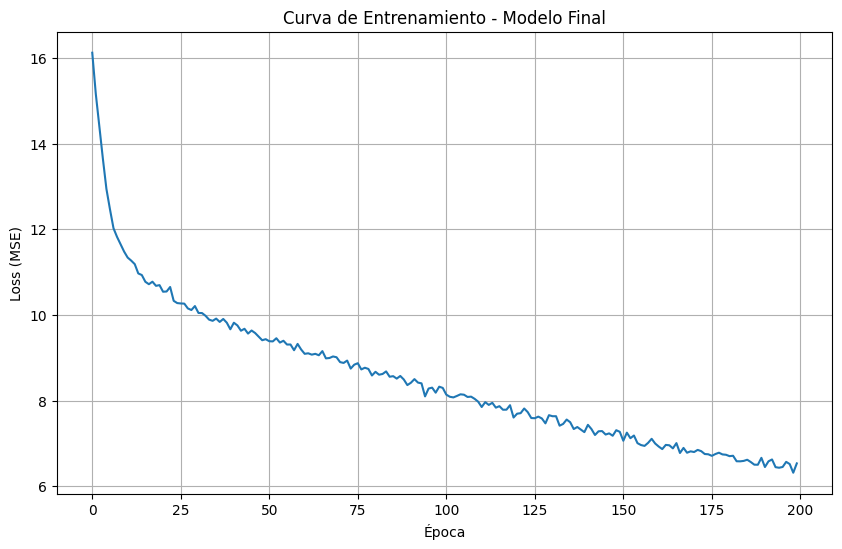

Modelo guardado exitosamente!


In [10]:
# Usar los mejores hiperparámetros encontrados
best_params = study.best_params

# Crear dataloaders con TODOS los datos de entrenamiento
_, _, full_train_loader = create_dataloaders(
    df_train_scaled, df_test_scaled, preprocessor,
    sequence_length=best_params['sequence_length'],
    batch_size=best_params['batch_size'],
    val_years=[]  # No usar validación, entrenar con todo
)

# Crear modelo final
input_size = len(preprocessor.feature_columns)
final_model = DengueLSTM(
    input_size=input_size,
    hidden_size=best_params['hidden_size'],
    n_layers=best_params['n_layers'],
    dropout=best_params['dropout']
).to(device)

# Configurar entrenamiento
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss()

# Entrenar modelo final
print("\nEntrenando modelo final con todos los datos...")
n_epochs_final = 200
train_losses = []

for epoch in range(n_epochs_final):
    train_loss = train_epoch(final_model, full_train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch + 1}/{n_epochs_final}, Loss: {train_loss:.4f}")

# Visualizar curva de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Curva de Entrenamiento - Modelo Final')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

# Guardar modelo
torch.save({
    'model_state_dict': final_model.state_dict(),
    'hyperparameters': best_params,
    'feature_columns': preprocessor.feature_columns,
    'scaler': preprocessor.scaler,
    'encoder': preprocessor.encoder
}, 'dengue_lstm_model.pth')

print("Modelo guardado exitosamente!")

In [11]:
def generate_predictions_2022(model, df_train_scaled, df_test_scaled, preprocessor, 
                            sequence_length, device):
    """Genera predicciones autoregresivas para todo 2022"""
    
    model.eval()
    predictions_2022 = []
    
    # Obtener todos los barrios
    barrios = sorted(df_train_scaled['id_bar'].unique())
    
    with torch.no_grad():
        for barrio in barrios:
            # Obtener datos históricos del barrio
            barrio_train = df_train_scaled[df_train_scaled['id_bar'] == barrio].sort_values('fecha')
            barrio_test = df_test_scaled[df_test_scaled['id_bar'] == barrio].sort_values('fecha')
            
            # Si hay datos en test, usar la combinación de train + test
            if len(barrio_test) > 0:
                barrio_data = pd.concat([barrio_train, barrio_test]).sort_values('fecha')
            else:
                barrio_data = barrio_train
            
            # Tomar las últimas 'sequence_length' semanas como input inicial
            last_sequence = barrio_data.tail(sequence_length).copy()
            
            # Generar predicciones para las 52 semanas de 2022
            for week in range(1, 53):
                # Preparar input
                X = torch.FloatTensor(
                    last_sequence[preprocessor.feature_columns].values
                ).unsqueeze(0).to(device)
                
                # Predecir
                pred = model(X).cpu().item()
                
                # Guardar predicción
                predictions_2022.append({
                    'id': f"{barrio}_2022_{week}",
                    'id_bar': barrio,
                    'anio': 2022,
                    'semana': week,
                    'dengue': max(0, pred)  # Asegurar no negativos
                })
                
                # Actualizar secuencia para predicción autoregresiva
                # Crear nueva fila con la predicción
                new_row = last_sequence.iloc[-1:].copy()
                new_row['dengue'] = pred
                new_row['semana'] = week
                new_row['anio'] = 2022
                
                # Actualizar fecha
                if week == 1:
                    new_row['fecha'] = pd.Timestamp('2022-01-03')  # Primer lunes de 2022
                else:
                    new_row['fecha'] = new_row['fecha'] + timedelta(weeks=1)
                
                # Actualizar secuencia eliminando la primera fila y agregando la nueva
                last_sequence = pd.concat([last_sequence.iloc[1:], new_row], ignore_index=True)
            
            print(f"Predicciones completadas para barrio {barrio}")
    
    return pd.DataFrame(predictions_2022)

# Generar predicciones
print("\nGenerando predicciones para 2022...")
predictions_df = generate_predictions_2022(
    final_model, df_train_scaled, df_test_scaled, 
    preprocessor, best_params['sequence_length'], device
)

print(f"\nForma de predicciones: {predictions_df.shape}")
print(predictions_df.head())

# Crear archivo de sumisión
submission_df = predictions_df[['id', 'dengue']]
submission_df.to_csv('submission_Claude_LSTM.csv', index=False)
print("\nArchivo submission.csv creado exitosamente!")

# Estadísticas de las predicciones
print("\n=== ESTADÍSTICAS DE PREDICCIONES ===")
print(f"Total de predicciones: {len(submission_df)}")
print(f"Promedio de casos predichos: {submission_df['dengue'].mean():.2f}")
print(f"Desviación estándar: {submission_df['dengue'].std():.2f}")
print(f"Mínimo: {submission_df['dengue'].min():.2f}")
print(f"Máximo: {submission_df['dengue'].max():.2f}")


Generando predicciones para 2022...
Predicciones completadas para barrio 0
Predicciones completadas para barrio 1
Predicciones completadas para barrio 2
Predicciones completadas para barrio 3
Predicciones completadas para barrio 4
Predicciones completadas para barrio 5
Predicciones completadas para barrio 6
Predicciones completadas para barrio 7
Predicciones completadas para barrio 8
Predicciones completadas para barrio 9

Forma de predicciones: (520, 5)
         id  id_bar  anio  semana  dengue
0  0_2022_1       0  2022       1  0.4687
1  0_2022_2       0  2022       2  0.0000
2  0_2022_3       0  2022       3  0.0000
3  0_2022_4       0  2022       4  0.0000
4  0_2022_5       0  2022       5  0.0000

Archivo submission.csv creado exitosamente!

=== ESTADÍSTICAS DE PREDICCIONES ===
Total de predicciones: 520
Promedio de casos predichos: 0.02
Desviación estándar: 0.13
Mínimo: 0.00
Máximo: 1.40


In [12]:
# Visualizar predicciones para algunos barrios
barrios_visualizar = predictions_df['id_bar'].unique()[:5]

fig = make_subplots(
    rows=len(barrios_visualizar), 
    cols=1,
    subplot_titles=[f'Barrio {b}' for b in barrios_visualizar],
    shared_xaxes=True,
    vertical_spacing=0.05
)

for i, barrio in enumerate(barrios_visualizar):
    # Datos históricos
    hist_data = df_train[df_train['id_bar'] == barrio].sort_values('fecha')
    
    # Predicciones 2022
    pred_data = predictions_df[predictions_df['id_bar'] == barrio].sort_values('semana')
    pred_data['fecha'] = pd.date_range(start='2022-01-03', periods=52, freq='W-MON')
    
    # Agregar trazas
    fig.add_trace(
        go.Scatter(
            x=hist_data['fecha'],
            y=hist_data['dengue'],
            mode='lines',
            name=f'Histórico - Barrio {barrio}',
            line=dict(color='blue'),
            showlegend=(i == 0)
        ),
        row=i+1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=pred_data['fecha'],
            y=pred_data['dengue'],
            mode='lines',
            name=f'Predicción 2022 - Barrio {barrio}',
            line=dict(color='red', dash='dash'),
            showlegend=(i == 0)
        ),
        row=i+1, col=1
    )

fig.update_layout(
    height=200*len(barrios_visualizar),
    title_text="Predicciones de Dengue para 2022 vs Datos Históricos",
    showlegend=True
)
fig.update_xaxes(title_text="Fecha", row=len(barrios_visualizar), col=1)
fig.update_yaxes(title_text="Casos")

fig.show()

# Visualización agregada
pred_aggregated = predictions_df.groupby('semana')['dengue'].sum().reset_index()
pred_aggregated['fecha'] = pd.date_range(start='2022-01-03', periods=52, freq='W-MON')

hist_aggregated = df_train.groupby('fecha')['dengue'].sum().reset_index()

fig = go.Figure()

# Histórico
fig.add_trace(go.Scatter(
    x=hist_aggregated['fecha'],
    y=hist_aggregated['dengue'],
    mode='lines',
    name='Histórico Total',
    line=dict(color='blue', width=2)
))

# Predicción
fig.add_trace(go.Scatter(
    x=pred_aggregated['fecha'],
    y=pred_aggregated['dengue'],
    mode='lines',
    name='Predicción 2022 Total',
    line=dict(color='red', width=2, dash='dash')
))

fig.update_layout(
    title='Predicción Total de Casos de Dengue para 2022 (Todos los Barrios)',
    xaxis_title='Fecha',
    yaxis_title='Casos Totales',
    hovermode='x unified',
    height=500
)
fig.show()

print("\n¡Proceso completado exitosamente!")
print(f"Se generaron {len(submission_df)} predicciones para el archivo de sumisión.")


¡Proceso completado exitosamente!
Se generaron 520 predicciones para el archivo de sumisión.
